In [3]:
import pandas as pd
import wikipedia as wp
import datetime
import yfinance as yf
import numpy as np
import scipy.sparse as sp
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.stats as spstats


class Portfolio:
    def __init__(self,tickers,start=datetime.date(2019,1,1),end=datetime.date.today()-datetime.timedelta(days=1)):
        #set cvx params
        
        self.tickers=tickers
        self.start=start
        self.end=end
        self.data = yf.download(tickers, start,end)
        self.prices=self.data['Adj Close']
        self.returns=np.log(self.prices/self.prices.shift(1))
        self.mu=self.returns.mean().to_numpy()
        self.Sigma=self.returns.cov().to_numpy()
        self.w = cp.Variable(len(self.tickers))
        self.gamma = cp.Parameter(nonneg=True)
        self.ret = self.mu.T @ self.w
        self.risk = cp.quad_form(self.w, self.Sigma)
        self.Lmax = cp.Parameter()
        
        
    def longonly(self,samples):
        #solve for long only portfolio
        
        self.LongOnly_prob = cp.Problem(cp.Maximize(self.ret - self.gamma * self.risk), [cp.sum(self.w) == 1, self.w >= 0]) #keep prob without self so that it can be reused at every problem
        self.LongOnly_risk_data = np.zeros(samples)
        self.LongOnly_ret_data = np.zeros(samples)
        self.gamma_vals = np.logspace(-2, 3, num=samples)
        for i in range(samples):
            self.gamma.value = self.gamma_vals[i]
            self.LongOnly_prob.solve()
            self.LongOnly_risk_data[i] = cp.sqrt(self.risk).value
            self.LongOnly_ret_data[i] = self.ret.value
    
    def leverage(self,samples,L_vals):
        # Portfolio optimization with leverage limit.
        
        self.Leverage_prob = cp.Problem(cp.Maximize(self.ret - self.gamma * self.risk), [cp.sum(self.w) == 1, cp.norm(self.w, 1) <= self.Lmax])
        self.Leverage_risk_data = np.zeros((len(L_vals), samples))
        self.Leverage_ret_data = np.zeros((len(L_vals), samples))
        self.gamma_vals2 = np.logspace(-2, 3, num=samples)
        for k, L_val in enumerate(L_vals):
            for i in range(samples):
                self.Lmax.value = L_val
                self.gamma.value = self.gamma_vals2[i]
                self.Leverage_prob.solve(solver=cp.SCS)
                self.Leverage_risk_data[k, i] = cp.sqrt(self.risk).value
                self.Leverage_ret_data[k, i] = self.ret.value
                
    def levandrisk(self,samples,L_vals):
        # Portfolio optimization with a leverage limit and a bound on risk.
        
        self.LeverageAndRisk_prob=cp.Problem(cp.Maximize(self.ret), [cp.sum(self.w) == 1, cp.norm(self.w, 1) <= self.Lmax, self.risk <= 2])

In [4]:
html = wp.page("Dow_Jones_Industrial_Average").html().encode("UTF-8")
dfwiki=pd.read_html(html)
tickers=list(dfwiki[1]['Symbol'])


In [5]:
tc=Portfolio(tickers)

[*********************100%***********************]  30 of 30 completed


In [6]:
tc.longonly(100)

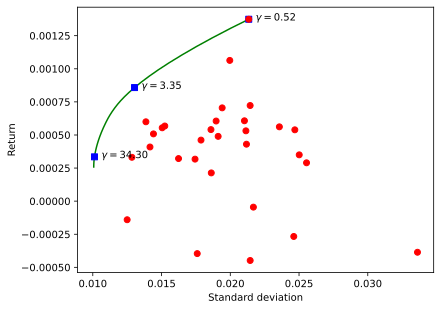

In [7]:


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [34, 50,70]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(tc.LongOnly_risk_data, tc.LongOnly_ret_data, "g-")
for marker in markers_on:
    plt.plot(tc.LongOnly_risk_data[marker], tc.LongOnly_ret_data[marker], "bs")
    ax.annotate(
        r"$\gamma = %.2f$" % tc.gamma_vals[marker],
        xy=(tc.LongOnly_risk_data[marker]+0.0005  , tc.LongOnly_ret_data[marker]-0.00001),
    )
for i in range(30):
    plt.plot(cp.sqrt(tc.Sigma[i, i]).value, tc.mu[i], "ro")
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.show()

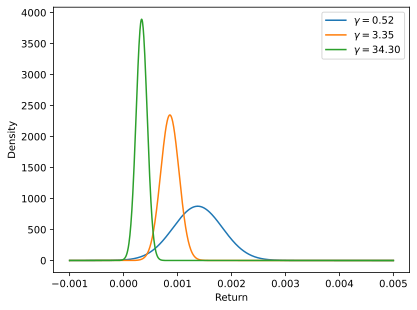

In [8]:



plt.figure()
for midx, idx in enumerate(markers_on):
    tc.gamma.value = tc.gamma_vals[idx]
    tc.LongOnly_prob.solve()
    x = np.linspace(-0.001, 0.005, 1000)
    plt.plot(
        x,
        spstats.norm.pdf(x, tc.ret.value, tc.risk.value),
        label=r"$\gamma = %.2f$" % tc.gamma.value,
    )

plt.xlabel("Return")
plt.ylabel("Density")
plt.legend(loc="upper right") 
plt.show()

In [9]:
L_vals=[1,2,4]
tc.leverage(100,L_vals)


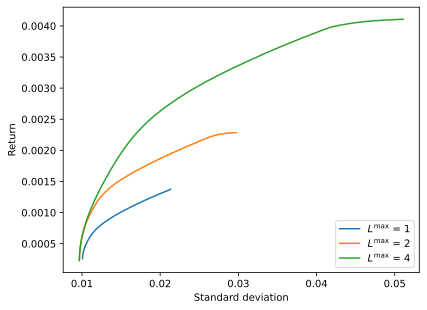

In [10]:

# Plot trade-off curves for each leverage limit.
for idx, L_val in enumerate(L_vals):
    plt.plot(tc.Leverage_risk_data[idx, :], tc.Leverage_ret_data[idx, :], label=r"$L^{\max}$ = %d" % L_val)
 
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.legend(loc="lower right")
plt.show()

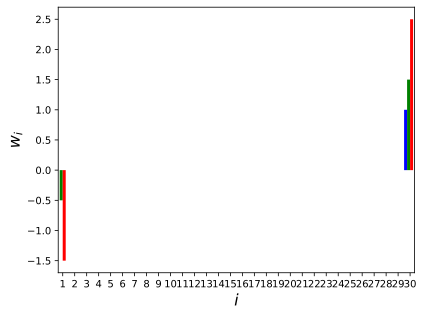

In [11]:
# Compute solution for different leverage limits.
w_vals=[]
tc.levandrisk(100,L_vals)
for k, L_val in enumerate(L_vals):
    tc.Lmax.value = L_val
    tc.LeverageAndRisk_prob.solve()
    w_vals.append(tc.w.value)
    
colors = ["b", "g", "r"]
indices = np.argsort(tc.mu.flatten())
for idx, L_val in enumerate(L_vals):
    plt.bar(
        np.arange(1, 31) + 0.25 * idx - 0.375,
        w_vals[idx][indices],
        color=colors[idx],
        label=r"$L^{\max}$ = %d" % L_val,
        width=0.25,
    )
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xlim([1 - 0.375, 30 + 0.375])
plt.xticks(np.arange(1, 31))
plt.show()    

In [2]:
!pip install wikipedia



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=7f9f039c6acc87b8faca95af64f96a820e77e91db9054d633b8fc9f61590cf59
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
